Install dependencies

In [1]:
!pip -q install --upgrade joblib scikit-learn xgboost
import numpy as np, joblib, sklearn, xgboost, json, os, sys, platform
print("Python:", sys.version)
print("Platform:", platform.platform())
print("numpy:", np.__version__)
print("scikit-learn:", sklearn.__version__)
print("xgboost:", xgboost.__version__)
print("joblib:", joblib.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 21.4 MB/s eta 0:00:00
Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Platform: Linux-6.6.105+-x86_64-with-glibc2.35
numpy: 2.0.2
scikit-learn: 1.8.0
xgboost: 3.1.2
joblib: 1.5.3


Upload 8 model artifacts

In [2]:
import os
from google.colab import files

ART_DIR = "/content/artifacts"
os.makedirs(ART_DIR, exist_ok=True)

uploaded = files.upload()  # select your files in the upload dialog

for name, data in uploaded.items():
    out_path = os.path.join(ART_DIR, name)
    with open(out_path, "wb") as f:
        f.write(data)

print("\nSaved to", ART_DIR)
print("Artifacts now present:")
for fn in sorted(os.listdir(ART_DIR)):
    print(" -", fn)

Saving best_cluster_model.pkl to best_cluster_model.pkl
Saving feature_cols.json to feature_cols.json
Saving norm_obj.pkl to norm_obj.pkl
Saving outlier_bounds.pkl to outlier_bounds.pkl
Saving pipeline_config.json to pipeline_config.json
Saving sampler_obj.pkl to sampler_obj.pkl
Saving scaler_obj.pkl to scaler_obj.pkl
Saving standardization_obj.pkl to standardization_obj.pkl

Saved to /content/artifacts
Artifacts now present:
 - best_cluster_model.pkl
 - feature_cols.json
 - norm_obj.pkl
 - outlier_bounds.pkl
 - pipeline_config.json
 - sampler_obj.pkl
 - scaler_obj.pkl
 - standardization_obj.pkl


Main function

In [8]:
%%writefile /content/build_cluster_space_cache.py
from __future__ import annotations

import argparse
import json
from pathlib import Path
from typing import Any, Dict, Tuple

import joblib
import numpy as np
from sklearn.decomposition import PCA


def _read_json(path: Path) -> Any:
    return json.loads(path.read_text(encoding="utf-8"))


def _bounds_for_feature(outlier_bounds: Any, col: str) -> Tuple[float, float]:
    """
    Try to read bounds for `col` from outlier_bounds.pkl.
    Supported formats:
      - dict[col] = [lo, hi]
      - dict[col] = {"lo": ..., "hi": ...}
    Fallback: [0, 1]
    """
    if isinstance(outlier_bounds, dict) and col in outlier_bounds:
        b = outlier_bounds[col]
        lo = hi = None
        if isinstance(b, (list, tuple)) and len(b) >= 2:
            lo, hi = b[0], b[1]
        elif isinstance(b, dict):
            lo = b.get("lo", None)
            hi = b.get("hi", None)

        if lo is not None and hi is not None:
            try:
                lo_f = float(lo)
                hi_f = float(hi)
                if np.isfinite(lo_f) and np.isfinite(hi_f) and hi_f > lo_f:
                    return lo_f, hi_f
            except Exception:
                pass

    return 0.0, 1.0


def _maybe_clip_outliers(X: np.ndarray, feature_cols: list[str], outlier_bounds: Any, outlier_method: str) -> np.ndarray:
    """
    If pipeline config uses outlier clipping, apply it. If 'none', no-op.
    """
    method = str(outlier_method or "none").lower()
    if method == "none":
        return X

    if not isinstance(outlier_bounds, dict):
        return X

    Xc = X.copy()
    for j, col in enumerate(feature_cols):
        b = outlier_bounds.get(col, None)
        if b is None:
            continue

        lo = hi = None
        if isinstance(b, (list, tuple)) and len(b) >= 2:
            lo, hi = b[0], b[1]
        elif isinstance(b, dict):
            lo = b.get("lo", None)
            hi = b.get("hi", None)

        try:
            if lo is not None and np.isfinite(float(lo)):
                Xc[:, j] = np.maximum(Xc[:, j], float(lo))
            if hi is not None and np.isfinite(float(hi)):
                Xc[:, j] = np.minimum(Xc[:, j], float(hi))
        except Exception:
            pass

    return Xc


def _transform(
    X_raw: np.ndarray,
    *,
    feature_cols: list[str],
    pipeline_config: dict,
    outlier_bounds: Any,
    norm_obj: Any,
    standardization_obj: Any,
    scaler_obj: Any,
) -> np.ndarray:
    # outliers (usually none)
    X = _maybe_clip_outliers(
        X_raw,
        feature_cols=feature_cols,
        outlier_bounds=outlier_bounds,
        outlier_method=pipeline_config.get("outlier_method", "none"),
    )

    # safety: replace non-finite with 0 before transforms
    bad = ~np.isfinite(X)
    if bad.any():
        X = X.copy()
        X[bad] = 0.0

    if hasattr(norm_obj, "transform"):
        X = norm_obj.transform(X)

    if hasattr(standardization_obj, "transform"):
        X = standardization_obj.transform(X)

    if hasattr(scaler_obj, "transform"):
        X = scaler_obj.transform(X)

    return np.asarray(X, dtype=float)


def _predict_labels(model: Any, X: np.ndarray) -> np.ndarray:
    """
    Predict cluster labels for each row in X.
    Works for sklearn-style estimators and XGBoost sklearn wrapper.
    """
    if hasattr(model, "predict"):
        y = model.predict(X)
        y = np.asarray(y).reshape(-1)
        # sometimes returns floats; cast safely
        try:
            return y.astype(int)
        except Exception:
            return np.array([int(v) for v in y], dtype=int)

    # fallback: if predict missing, try proba
    if hasattr(model, "predict_proba"):
        P = model.predict_proba(X)
        P = np.asarray(P, dtype=float)
        return np.argmax(P, axis=1).astype(int)

    raise RuntimeError("Model has neither predict nor predict_proba.")


def main():
    ap = argparse.ArgumentParser()
    ap.add_argument("--artifacts", type=str, default="/content/artifacts", help="Artifacts directory")
    ap.add_argument("--n_samples", type=int, default=900, help="How many cloud points to generate")
    ap.add_argument("--seed", type=int, default=42, help="Deterministic seed")
    ap.add_argument("--out_joblib", type=str, default="cluster_space_cache.joblib", help="Output joblib filename")
    ap.add_argument("--out_json", type=str, default="cluster_space_cache.json", help="Output json filename")
    args = ap.parse_args()

    art = Path(args.artifacts)

    MODEL_PATH = art / "best_cluster_model.pkl"
    NORM_PATH = art / "norm_obj.pkl"
    OUTLIER_PATH = art / "outlier_bounds.pkl"
    SCALER_PATH = art / "scaler_obj.pkl"
    STANDARD_PATH = art / "standardization_obj.pkl"
    FEATURE_COLS_PATH = art / "feature_cols.json"
    PIPELINE_CFG_PATH = art / "pipeline_config.json"

    # Load artifacts
    model = joblib.load(MODEL_PATH)
    norm_obj = joblib.load(NORM_PATH)
    outlier_bounds = joblib.load(OUTLIER_PATH)
    scaler_obj = joblib.load(SCALER_PATH)
    standardization_obj = joblib.load(STANDARD_PATH)

    feature_cols = _read_json(FEATURE_COLS_PATH)
    pipeline_config = _read_json(PIPELINE_CFG_PATH)

    if not isinstance(feature_cols, list) or not feature_cols:
        raise ValueError("feature_cols.json must be a non-empty list")

    # Sample raw engineered feature vectors using bounds
    rng = np.random.default_rng(args.seed)
    n = int(args.n_samples)
    d = len(feature_cols)

    X_raw = np.zeros((n, d), dtype=float)
    for j, col in enumerate(feature_cols):
        lo, hi = _bounds_for_feature(outlier_bounds, col)
        if not np.isfinite(lo) or not np.isfinite(hi) or hi <= lo:
            lo, hi = 0.0, 1.0
        X_raw[:, j] = rng.uniform(lo, hi, size=n)

    # Apply transforms
    X_trans = _transform(
        X_raw,
        feature_cols=feature_cols,
        pipeline_config=pipeline_config,
        outlier_bounds=outlier_bounds,
        norm_obj=norm_obj,
        standardization_obj=standardization_obj,
        scaler_obj=scaler_obj,
    )

    # Predict labels
    y = _predict_labels(model, X_trans)

    # PCA(2) in transformed space
    pca = PCA(n_components=2, random_state=args.seed)
    XY = pca.fit_transform(X_trans)

    points = []
    for i in range(n):
        points.append({
            "x": float(XY[i, 0]),
            "y": float(XY[i, 1]),
            "k": int(y[i]),
            "isUser": False,
        })

    payload = {
        "points": points,
        "pca_mean": pca.mean_.astype(float).tolist(),
        "pca_components": pca.components_.astype(float).tolist(),  # shape (2, d)
        "feature_cols": feature_cols,
        "meta": {
            "seed": int(args.seed),
            "n_samples": int(n),
            "n_features": int(d),
            "pipeline_outlier_method": str(pipeline_config.get("outlier_method", "none")),
        },
    }

    out_joblib_path = art / args.out_joblib
    out_json_path = art / args.out_json

    joblib.dump(payload, out_joblib_path)
    out_json_path.write_text(json.dumps(payload), encoding="utf-8")

    print("Wrote:")
    print(" -", out_joblib_path)
    print(" -", out_json_path)
    print("Points:", len(points), "| Features:", d)


if __name__ == "__main__":
    main()

Overwriting /content/build_cluster_space_cache.py


Builder script to create the cache files

In [9]:
!python /content/build_cluster_space_cache.py --artifacts /content/artifacts --n_samples 900 --seed 42

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:463: InconsistentVersionWarning: Trying to unpickle estimator RobustScaler from version 1.6.1 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
Wrote:
 - /content/artifacts/cluster_space_cache.joblib
 - /content/artifacts/cluster_space_cache.json
Points: 900 | Features: 37


Confirm the cache file exists

In [10]:
import os

ART_DIR = "/content/artifacts"   # change if used a different folder
print("Artifacts dir:", ART_DIR)
print("Files:", os.listdir(ART_DIR))

joblib_path = os.path.join(ART_DIR, "cluster_space_cache.joblib")
json_path   = os.path.join(ART_DIR, "cluster_space_cache.json")

print("\nFound joblib:", os.path.exists(joblib_path), joblib_path)
print("Found json  :", os.path.exists(json_path), json_path)

Artifacts dir: /content/artifacts
Files: ['feature_cols.json', 'norm_obj.pkl', 'scaler_obj.pkl', 'sampler_obj.pkl', 'best_cluster_model.pkl', 'pipeline_config.json', 'standardization_obj.pkl', 'cluster_space_cache.json', 'cluster_space_cache.joblib', 'outlier_bounds.pkl']

Found joblib: True /content/artifacts/cluster_space_cache.joblib
Found json  : True /content/artifacts/cluster_space_cache.json


Load with plot check

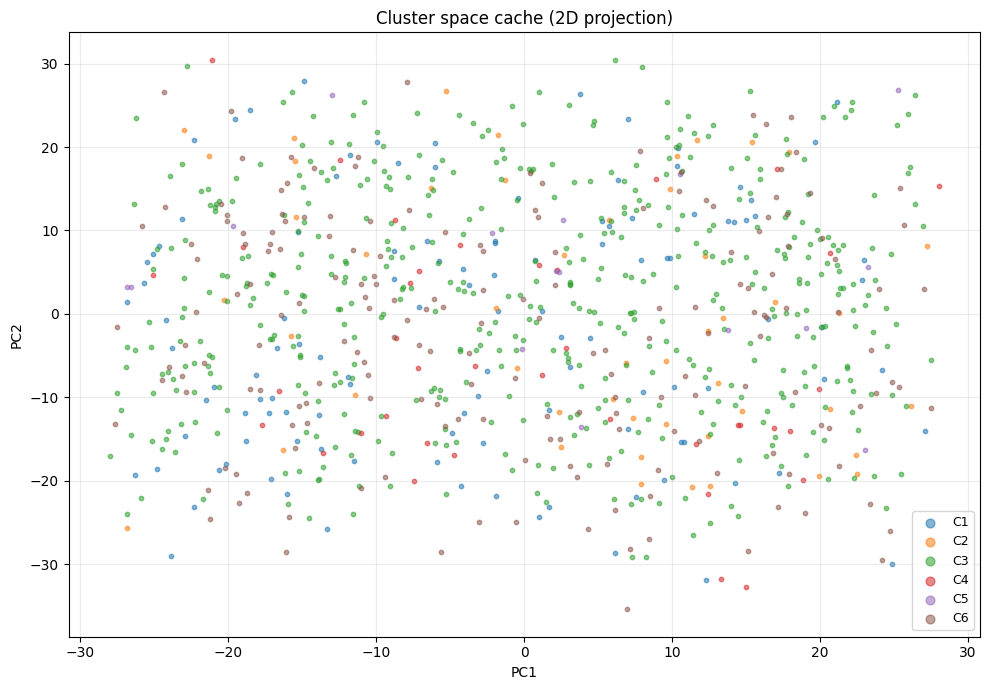

Points: 900
Clusters present: [0, 1, 2, 3, 4, 5]
Meta keys: ['seed', 'n_samples', 'n_features', 'pipeline_outlier_method']


In [11]:
import os, json
import numpy as np
import matplotlib.pyplot as plt

ART_DIR = "/content/artifacts"
joblib_path = os.path.join(ART_DIR, "cluster_space_cache.joblib")
json_path   = os.path.join(ART_DIR, "cluster_space_cache.json")

payload = None
if os.path.exists(joblib_path):
    import joblib
    payload = joblib.load(joblib_path)
elif os.path.exists(json_path):
    with open(json_path, "r", encoding="utf-8") as f:
        payload = json.load(f)
else:
    raise FileNotFoundError("Missing cluster_space_cache.joblib/json in ART_DIR")

points = payload.get("points", [])
if not points:
    raise ValueError("payload['points'] is empty. The cache file exists but has no points.")

# arrays
x = np.asarray([p["x"] for p in points], dtype=float)
y = np.asarray([p["y"] for p in points], dtype=float)
k = np.asarray([p.get("k", -1) for p in points], dtype=int)

# optional user point (some versions store it)
user_point = payload.get("user_point", None)

plt.figure(figsize=(10, 7))

# plot each cluster separately (matplotlib default colors)
for kk in sorted(set(k.tolist())):
    mask = (k == kk)
    label = f"C{kk+1}" if kk >= 0 else "Unknown"
    plt.scatter(x[mask], y[mask], s=10, alpha=0.55, label=label)

# optional user point overlay
if isinstance(user_point, dict) and "x" in user_point and "y" in user_point:
    plt.scatter([float(user_point["x"])], [float(user_point["y"])], s=80, alpha=0.95, label="You")

plt.title("Cluster space cache (2D projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True, alpha=0.25)
plt.legend(markerscale=2, fontsize=9, frameon=True)
plt.tight_layout()
plt.show()

# quick summary
meta = payload.get("meta", {})
print("Points:", len(points))
print("Clusters present:", sorted(set(k.tolist())))
print("Meta keys:", list(meta.keys()) if isinstance(meta, dict) else type(meta))

Download the output files

In [12]:
from google.colab import files
files.download("/content/artifacts/cluster_space_cache.joblib")
files.download("/content/artifacts/cluster_space_cache.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>